## Measuring cache size dependence in the memory latency of ec2 instances
>Team 4 - HW2 - DSC 291 - April 20, 2020 - Univ. of Calif. SD


In [9]:
%pylab inline
# %pdb
#initialize namespaces
import os, sys, shutil, time, datetime
import pandas as pd, scipy.stats as stats
from numpy import *
from matplotlib.backends.backend_pdf import PdfPages
from os.path import isfile,isdir
from os import mkdir
from lib.measureRandomAccess import measureRandomAccess
from lib.measureRandomAccessMemBlocks import *
from lib.PlotTime import PlotTime
from IPython.display import Image
if 'nb_dir' not in globals():
    nb_dir = os.getcwd()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axis']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Question: How does the performance of random-poke.py relate to the size of the L3 cache in the ec2 instance?


### Abstract
We control for instance features by looking for differences two similar yet distinct ec2 instance types: t3a.small and t2.small.  t3a.small and t2.small are general purpose instances which have similar architectures besides their cache sizes. We performed the following analysis by running performing 1 million memory pokes on varying block sizes once per minute over the course of an hour to analyze the performance of random-poke.py on their L3 cache sizes.

### Key Results
* In general, t3a.small and t2.small perform similarly when the data block size fits within both of their L3 cache sizes.
* Overall, t3a.small performs faster than t2.small on all block sizes greater than 30MB, which is expected since t3a.small has an L3 cache size of 64MB and t2.small only has an L3 cache size of 30MB.

## Description of the fields

__**Explanatory Variables/Inputs**__
* **datetime** the time and date
* **type** the type of instance
* **k** number of pokes per location poked
* **batch** the number of locations poked in a single trial experiment (multiple pokes performed using numpy, rather than python loop)

__**Dependent Variables/Outputs**__
* **_mean** mean latency of trial in seconds
* **_std** mean latency of trial in seconds
* **T** list the latency times
* **latency** delay between instructions

## Description of Experiment:

**Experimental Design:** We measured performance of the t2.small and t3a.small EC2 instances in terms of their latency when performing random-poke.py with varying block sizes.  In particular, t2.small has an L3 cache size of 30MB and t3a.small has an L3 cache size of 64MB. To keep other variables constant as much as possible, these EC2 instances were chosen because they each have 2 cores and 2 GiB of memory. 

Our experiment consisted of choosing a single hour to run random reads/writes to ec2 instance memory with varying block sizes, once per minute, on both a t2.small EC2 instance and a t3a.small EC2 instance. The block sizes ranged from size 10MB to 90MB, and was increased by 10MB at each step. We computed the mean and standard deviations of the latency times for each instance on the varying block sizes, once per minute, over the course of an hour. We then compared the means and standard deviations of the latency times between the two EC2 instances in order compare their respective performance.  

We chose t2.small and t3a.small instances because they are similar with the exception of their differing cache sizes.  __This choice lets us perform a controlled measurement of the effect only varying the L3 cache size has on the performance in terms of latency.__


## Description of Experiment (cont'd):
We test the following hypotheses

**Null Hypothesis:** L3 cache sizes have no effect on the performance of ec2 clusters for block sizes = 10, 20, 30, 40, 50, 60, 70, 80, 90 MB. 
Alternate Hypothesis: Higher cache size leads to lower latency times (better performance) depending on the block size.<br>

**Qualitative Hypothesis:** We expect t2.small and t3a.small to perform similarly when the given block size fits within both of their caches. Since t3a.small has a larger cache size than t2.small, on block sizes which are larger than the L3 cache of t2.small but smaller than the L3 cache of t3a.small, we expect t3a.small to outperform t3.small.<br>

**Hypothesis Testing:** In particular, a p-test will be done separately for each block size. We will report the block sizes which have significant differences in their latency times, and conclude with how EC2 instances' performance relates to the L3 cache size.

### setting parameters
* We test access to elements arrays whose sizes are:
   * 10MB, 20MB, 30MB, 40MB, 50MB, 60MB, 70MB, 80MB, 90MB
   
* On the EC2 instances:
   * t3a.small and t2.small
   
* Whose L3 cache sizes are: 
   * t3a.small: 64 MB
   * t2.small: 30 MB

* We perform 1 million read/write ops  to random locations in the array.
* We analyze the **distribution** of the latencies.

In [2]:
n=100 # size of single block (1MB)
m_list=[1,10,100,1000,10000] # size of file in blocks
k=100000;  # number of repeats
L=len(m_list)
print('n=%d, k=%d, m_list='%(n,k),m_list)

_mean=zeros([2,L])   #0: using disk, 1: using memory
_std=zeros([2,L])
Tmem=[]; TFile=[]
m_list=[10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000]
m_legend=['10MB', '20MB', '30MB', '40MB', '50MB', '60MB', '70MB']

n=100, k=100000, m_list= [1, 10, 100, 1000, 10000]


In [3]:
# %run python/aws-jupyter-scripts/run_trial.py

In [4]:
#collect data without verbose printing

#this cell shows reproducibility at short time scales.  We separately show reproducibility at long time scales
#create and store the results. 
#loop for the code below to run a trial of random_pokes() once per minute.

os.chdir(nb_dir)
num_trials = 0
while num_trials < 3:   # number of trials to run of time length x in time.sleep(x)
    # now = datetime.datetime.now()
    now=str(int(time.time()))
    print(f"trial completed at {str(now)}")
    %run python/aws-jupyter-scripts/run_trial.py
    time.sleep(10)#sleep for 10 seconds
    num_trials += 1

trial completed at 1587505877
 99900 trial completed at 1587505897
 99900 trial completed at 1587505916
 99900 

## How to read log-log survival plots
Plotted is unity minus the cummulative distribution function (CDF) for the normal distribution (left) and for cache hits/misses (right).    The crossing of the dotted line and the solid line indicates where the latencies become larger and more common than normally distributed latencies.

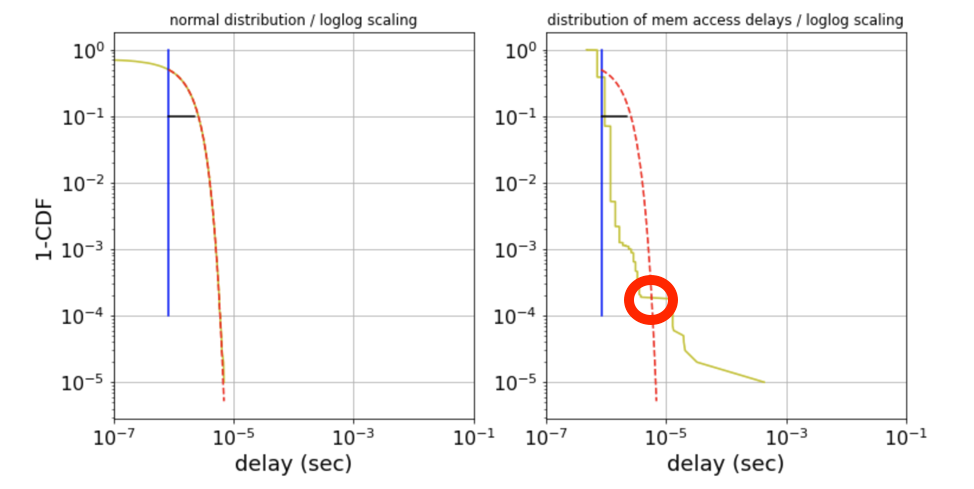

In [5]:
img_fn = f'{nb_dir}/fig/fig_a_highlighted.png'
assert(os.path.exists(img_fn))
Image(filename=img_fn, width = 600)

## Single trial run latency visualization for t3a.small: 
(see more slides below!)

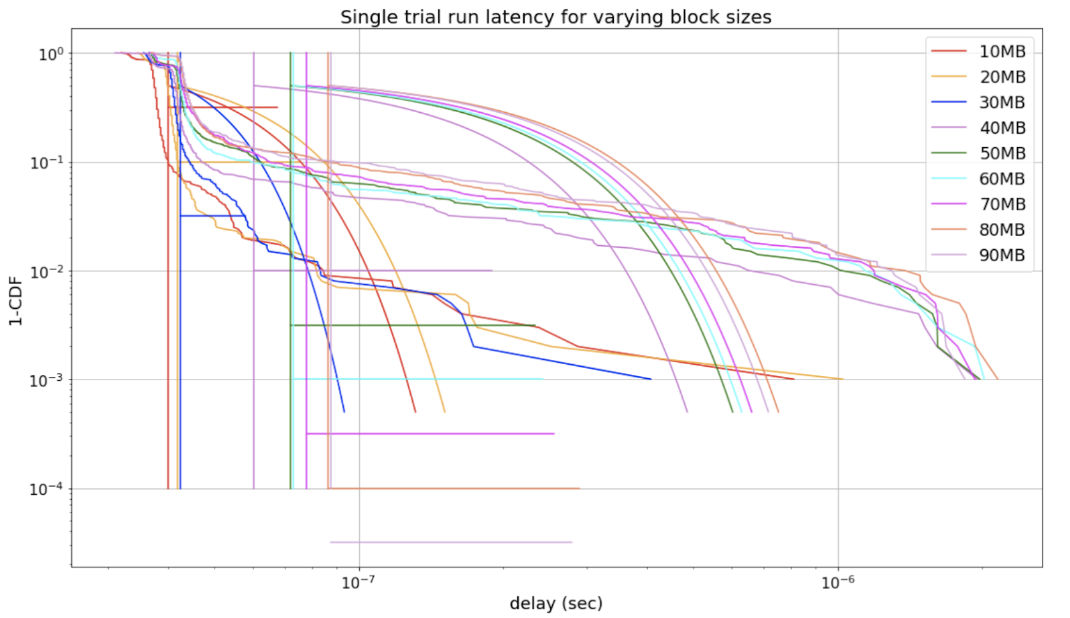

In [6]:
img_fn = f'{nb_dir}/fig/t3a_small_final.png'
assert(os.path.exists(img_fn))
Image(filename=img_fn, width = 800)

## Single trial run latency visualization for t2.small: 

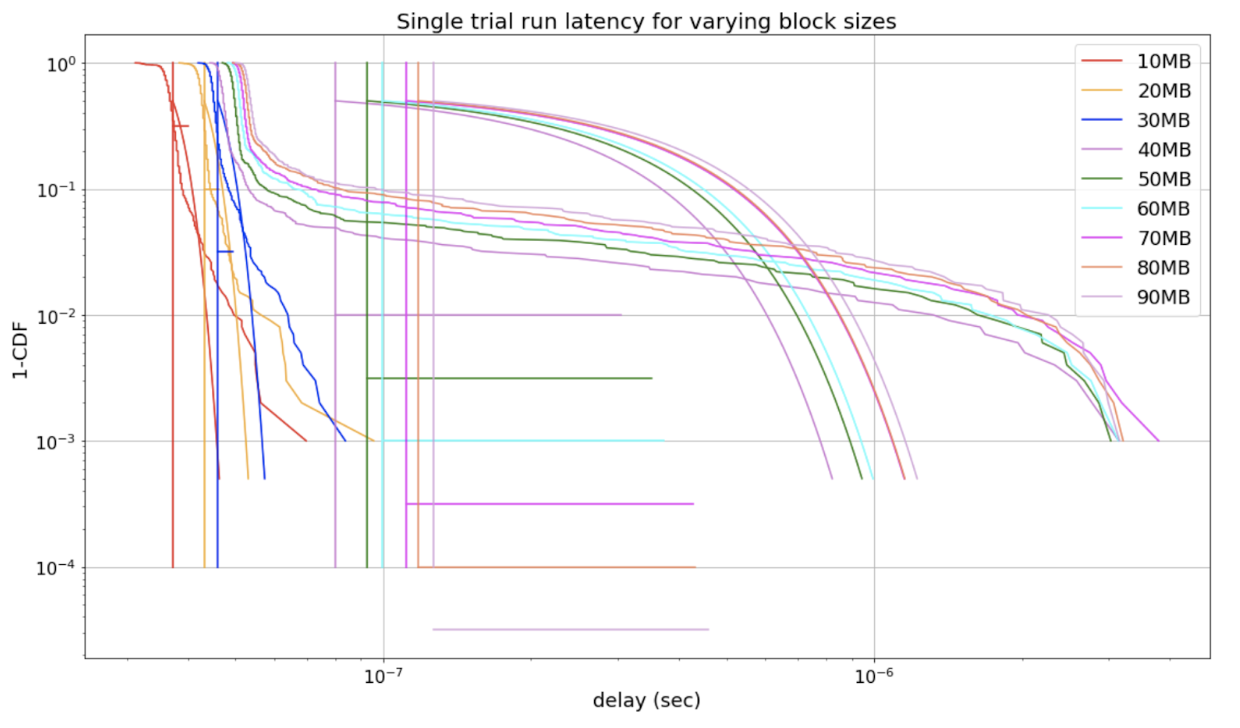

In [7]:
img_fn = f'{nb_dir}/fig/t2_small_final.png'
assert(os.path.exists(img_fn))
Image(filename=img_fn, width = 800)

# Discussion of the above
These two visualizations represent the typical plots of latency for the varying block sizes. Each of these trials are performed once per minute over the course of an hour to get our data. The global data (taken over the entire hour) is summarized in a later visualization below. 

In these trials, we see that the two ec2 instances perform similarly on block sizes of 10MB, 20MB, and 30MB. This supports our hypothesis that the two instances will have similar latency times when the entire block size fits in memory; however, we see a jump in latency in both instances after 30 MB. This indicates cache-miss rates suddenly become more common as block size is increased beyond 30MB for both instances.  This sudden drop in performance is consistent with the memory capacity of the L2 cache of ec2 instances (a table of cache sizes is shown below).

Not only does t3a.small out-perform t2.small on block sizes of 40MB, 50MB, and 60MB, as expected, it also outperforms t2.small on block sizes of 70MB, 80MB, and 90MB as well. These representative trials indicate that the larger cache size does indeed tend to improve the performance of an ec2 instance in terms of its latency; however, statistical tests will need to be performed to validate these claims. 


The above trial was conducted at 5pm on Monday 4/20/2020.

# Statistical comparison of t3a.small instances and t2.small instances

In [4]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import ttest_ind
from matplotlib.figure import Figure

t3asmall = pickle.load( open( 'data/t3asmall.pkl', "rb" ) )
t2small = pickle.load(open('data/t2small.pkl', 'rb'))
t3asmall_df = pd.DataFrame(t3asmall)
t2small_df  = pd.DataFrame(t2small)
m_legend = ['10MB', '20MB', '30MB', '40MB', '50MB', '60MB', '70MB', '80MB', '90MB']

In [5]:
t3asmall_df['memory_min'] = t3asmall_df['memory_latencies'].apply(lambda x: min(x))
t3asmall_df['memory_max'] = t3asmall_df['memory_latencies'].apply(lambda x: max(x))
t2small_df['memory_min'] = t2small_df['memory_latencies'].apply(lambda x: min(x))
t2small_df['memory_max'] = t2small_df['memory_latencies'].apply(lambda x: max(x))

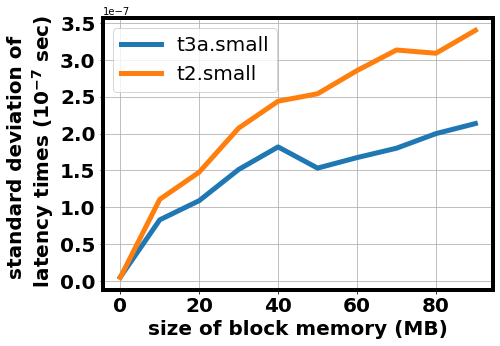

In [6]:
# m_legend = ['1 Byte', '10MB', '20MB', '30MB', '40MB', '50MB', '60MB', '70MB', '80MB', '90MB']
x_values = [0,10,20,30,40,50,60,70,80,90]
# m_legend = ['00MB', '10MB', '20MB', '30MB', '40MB', '50MB', '60MB', '70MB', '80MB', '90MB']
fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(111)
fontsize = 20
ax.plot(x_values, t3asmall_df['memory__std'].values ,label='t3a.small', lw=5)
ax.plot(x_values, t2small_df['memory__std'].values ,label='t2.small', lw=5)
ax.set_xlabel('size of block memory (MB)', fontweight='bold', fontsize=fontsize)
ax.set_ylabel('standard deviation of \n latency times ($\mathbf{10^{-7}}$ sec)', fontweight='bold', fontsize=fontsize)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
ax.legend(fontsize=fontsize)
ax.grid(None)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
plt.show()


## Comparing our two instances with a t-test
| Instance Type | Processor | L1d cache | L2 cache | L3 cache |
| --- | --- | --- |--- | --- |
| t2.small | Intel Xeon E5-2676 | 12 x 32 KB |12 x 256 KB |30 MB|
| t3a.small | AMD EPYC 7571 | 32 x 32 KB |	32 x 512 KB |8 x 8 MB|

The effecticve cache size of t2.small instance is $\sim 30$ MB.<br>
The effecticve cache size of t3a.small instance is $\sim64$ MB<br>

In [7]:
print('''t-tests comparing the largest latencies of 
t2.small and t3a.small instances over multiple trials 
(controlling for time of day, day of week, etc.):
''')
for idx in range(1, 10):
    t3 = t3asmall_df.loc[idx, 'memory_latencies']
    t2 = t2small_df.loc[idx, 'memory_latencies']
    pvalue = ttest_ind(t3, t2).pvalue
    answer = "is" if pvalue<0.05 else "is not"
    print(f'{idx}0MB has p = {pvalue:.5f}, which {answer} stastistically significant.')
    print()

t-tests comparing the largest latencies of 
t2.small and t3a.small instances over multiple trials 
(controlling for time of day, day of week, etc.):

10MB has p = 0.53511, which is not stastistically significant.

20MB has p = 0.83510, which is not stastistically significant.

30MB has p = 0.31732, which is not stastistically significant.

40MB has p = 0.30909, which is not stastistically significant.

50MB has p = 0.06267, which is not stastistically significant.

60MB has p = 0.03036, which is stastistically significant.

70MB has p = 0.01621, which is stastistically significant.

80MB has p = 0.01549, which is stastistically significant.

90MB has p = 0.00378, which is stastistically significant.



# A more detailed visualization of behavior averaged over many trials
(see plot below!)<br>
The results from the graph above, which depicts the latency times of the ec2 instances t3a.small and t2.small over the entire hour, with each trial ran once per minute, demonstrates the consistent results of t3a.small out-performing t2.small. Additionally, we see that there is generally an increase in latency occuring above 33 MB, when the L2 cache limit is exceeded; however, t3a.small is able to outperform t2.small due to its larger L3 cache size. 

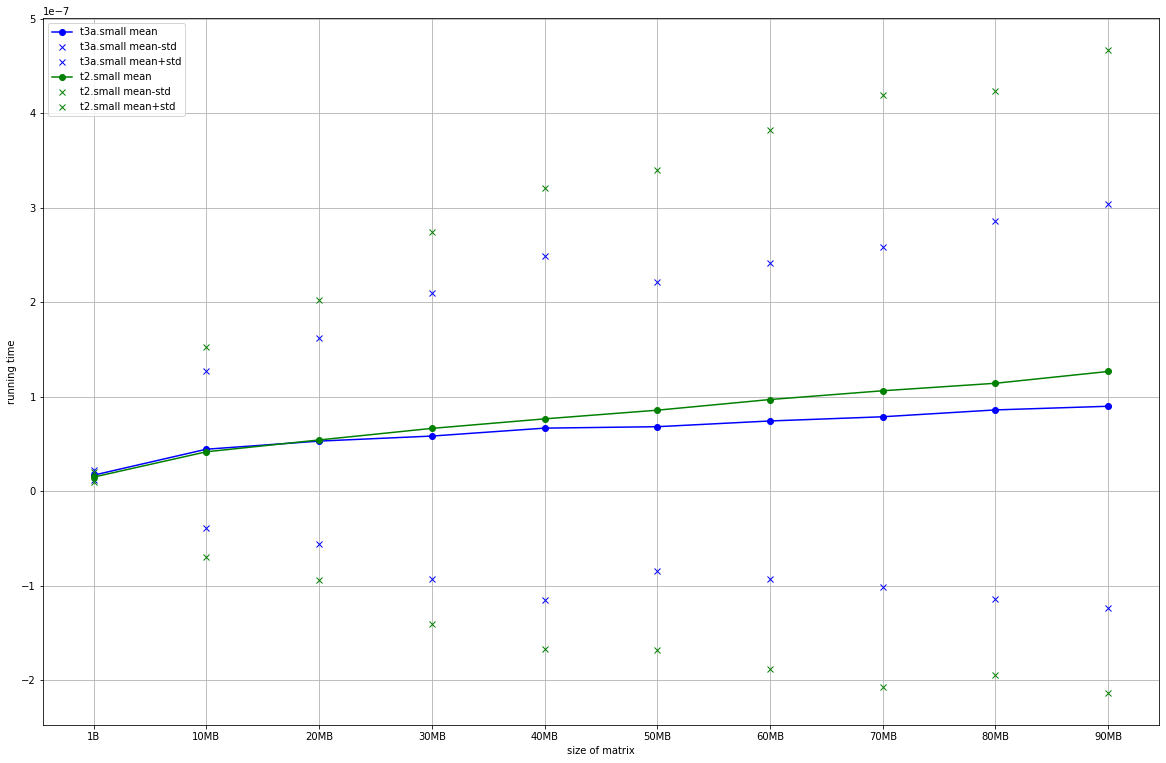

In [8]:
m_legend=['1B','10MB', '20MB', '30MB', '40MB', '50MB', '60MB', '70MB', '80MB', '90MB']
plt.figure(figsize=(20,13))
plt.plot(m_legend, t3asmall_df['memory__mean'],'o-b',label='t3a.small mean')
plt.plot(m_legend,t3asmall_df['memory__mean']-t3asmall_df['memory__std'],'xb',label='t3a.small mean-std')
plt.plot(m_legend,t3asmall_df['memory__mean']+t3asmall_df['memory__std'],'xb',label='t3a.small mean+std')
plt.plot(m_legend, t2small_df['memory__mean'],'o-g',label='t2.small mean')
plt.plot(m_legend,t2small_df['memory__mean']-t2small_df['memory__std'],'xg',label='t2.small mean-std')
plt.plot(m_legend,t2small_df['memory__mean']+t2small_df['memory__std'],'xg',label='t2.small mean+std')
plt.xlabel('size of matrix')
plt.ylabel('running time')
plt.legend()
plt.grid()

## Conclusion
 - The p-values for the case of 10, 20, 30, 40, 50 MB have $p>0.05$ and therefore there is no significant difference between the two instance types. For the larger block sizes, we see a significant difference between the two instance types.
 - Our hypotheis is validated by the statistical test because when the block size becomes considerably larger the L3 cache size of the t2.small instance but is still smaller than the L3 cache size of t3a.small, than the t3a.small performs better than t2.small.

# Acknowledgments
Many components producing the results in this notebook were sourced from the course material for DSC 291 at the University of California San Diego under the instruction of Yoav Freund.  Source material may be freely installed using 
> $ git clone https://github.com/yoavfreund/Public-DSC291

# Distribution of Hours Spent
Team 4 collectively spent 90 hours on this homework 2
- Domain  (30 hours): tttyree@ucsd.edu
- Methods (30 hours): r2aggarw@ucsd.edu Ria Agarwal
- Mehtods (30 hours): pjsimmon@ucsd.edu Purisa Jasmine Simmons